<h1>Fine Tuning MobileNet

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Dataset Preperation and Preprocessing

In [6]:
os.chdir('MobileNetDataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('test')
    os.mkdir('valid')
    for i in range(10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../')

In [7]:
train_path = 'MobileNetDataset/train'
test_path = 'MobileNetDataset/test'
valid_path = 'MobileNetDataset/valid'

In [8]:
# Preprocess Image Data for Keras
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


<h2>Modify Model

In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [6]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [8]:
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

In [9]:
model = Model(inputs=mobile.input, outputs=output)

In [10]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

<h2>Train the model

In [12]:
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    steps_per_epoch=171,
    validation_steps=30,
    epochs=10,
    verbose=2
)

Epoch 1/10
171/171 - 106s - loss: 0.6514 - accuracy: 0.8143 - val_loss: 0.2322 - val_accuracy: 0.9467
Epoch 2/10
171/171 - 100s - loss: 0.1415 - accuracy: 0.9706 - val_loss: 0.1227 - val_accuracy: 0.9667
Epoch 3/10
171/171 - 100s - loss: 0.0592 - accuracy: 0.9941 - val_loss: 0.0929 - val_accuracy: 0.9700
Epoch 4/10
171/171 - 100s - loss: 0.0383 - accuracy: 0.9965 - val_loss: 0.0701 - val_accuracy: 0.9833
Epoch 5/10
171/171 - 100s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9800
Epoch 6/10
171/171 - 101s - loss: 0.0180 - accuracy: 0.9988 - val_loss: 0.0498 - val_accuracy: 0.9833
Epoch 7/10
171/171 - 101s - loss: 0.0154 - accuracy: 0.9988 - val_loss: 0.0521 - val_accuracy: 0.9800
Epoch 8/10
171/171 - 101s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9767
Epoch 9/10
171/171 - 101s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 0.9867
Epoch 10/10
171/171 - 101s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0506 - 

<h2>Predict sign language digits

In [9]:
test_labels = test_batches.classes

In [10]:
predictions = model.predict(x=test_batches, verbose=0)

In [11]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [12]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [13]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues
                         ):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Conusion Matrix without Normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else "black"
                )
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

Conusion Matrix without Normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 1 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


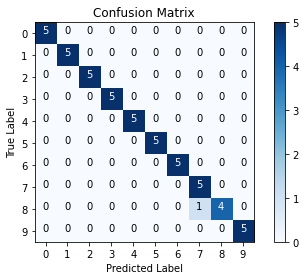

In [14]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [15]:
acc=sum(cm.diagonal())/sum(sum(cm))*100
print("Accuracy = "+str(acc)+"%")

Accuracy = 98.0%
